In [13]:
import torch
import fastai

### Data Augmentation and Dataloaders

In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_trans = transforms.Compose([
              transforms.Resize((224,224)),
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(15),
              transforms.ToTensor(), 
              transforms.Normalize(mean = [0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset = datasets.ImageFolder(root = "../PokemonData", transform = data_trans)

train_size = int(len(dataset) * 0.8)
dev_size = int(len(dataset) - train_size)

train_set, dev_set = random_split(dataset, [train_size, dev_size])

batchSize = 16

train_loader = DataLoader(train_set, batch_size = batchSize, shuffle = True, num_workers = 3)
dev_loader = DataLoader(dev_set, batch_size = batchSize, shuffle = False, num_workers = 3)

In [15]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

### Displaying Training Images

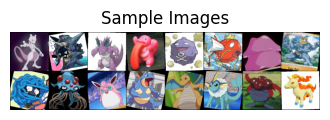

In [16]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

batch = next(iter(train_loader))
plt.figure(figsize = (4,4))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:16], padding = 2, normalize = True).cpu(), (1,2,0)))

### Transfer Learning with ResNet101

In [17]:
import torchvision.models as models
import torch.nn as nn
model = models.resnet101(weights="ResNet101_Weights.DEFAULT")
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Linear(512, 150, bias = True))
model = model.to(device)

In [18]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

### Training Model

In [19]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = .01)
criterion = nn.CrossEntropyLoss()

In [20]:
num_epochs = 5

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for inputs, labels in train_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

       
    print(f'Epoch : {epoch + 1} Loss: {epoch_loss / len(train_loader)}')

Epoch : 1 Loss: 3.5913577740874616
Epoch : 2 Loss: 0.8089949103143714
Epoch : 3 Loss: 0.26453954502280835
Epoch : 4 Loss: 0.14129805678891838
Epoch : 5 Loss: 0.0876213029565449


### Saving Model

In [21]:
torch.save(model.state_dict(), 'pokemodel.pt')

### Evaluating Model

In [22]:
def eval_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(dev_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_acc = 100.0 * correct / total
    print(f'Accuracy of model on test images: {test_acc}')
    return test_acc

In [23]:
eval_model(model)

Accuracy of model on test images: 91.22418879056048


91.22418879056048